In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import pyblock
from scipy.special import logsumexp
from scipy.special import softmax

# matplotlib settings
# --- Publication style settings ---
plt.rcParams.update({
    # Font
    "font.family": "Times New Roman",
    "font.serif": ["Arial"],  # or other preferred serif font
    "mathtext.fontset": "cm",            # Computer Modern for math text
    "text.usetex": False,                 # Use LaTeX for text rendering]
    "pdf.fonttype": 42,                 # Use LaTeX for text rendering

    # Figure
    "figure.figsize": (6, 4),            # width, height in inches
    "figure.dpi": 300,                   # high resolution

    # Axes
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "axes.linewidth": 1.2,
    "axes.grid": True,                   # optional, remove if you want no grid
    "grid.linestyle": "--",
    "grid.alpha": 0.7,

    # Ticks
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.top": True,
    "ytick.right": True,

    # Lines
    "lines.linewidth": 2,
    "lines.markersize": 6,

    # Legend
    "legend.fontsize": 10,
    "legend.frameon": False
})

# functions
# read_colvar function which sorts colvar for unique entries from the back (i.e., second entry retained)
def read_colvar(colvar_file):

    data = np.loadtxt(colvar_file)
    # inverse order
    data = data[::-1]
    unique_idxs = np.array(np.unique(data[:,0], return_index=True)[1]).astype(int)[::-1] # find unique indices, first occurences
    data = data[unique_idxs]
    # original order
    data = data[::-1]

    return data

# Function to calculate helical fraction
def helical_fraction(ss_line):
    helix_chars = {'H', 'G', 'I'}
    n_residues = len(ss_line)
    n_helical = sum(1 for c in ss_line if c in helix_chars)
    return n_helical / n_residues


def weighted_sem(x, w):
    x = np.asarray(x, dtype=float)
    w = np.asarray(w, dtype=float)

    # weighted mean
    mean_w = np.sum(w * x) / np.sum(w)

    # effective sample size
    n_eff = (np.sum(w) ** 2) / np.sum(w ** 2)

    # unbiased weighted variance
    variance_w = np.sum(w * (x - mean_w) ** 2) / (
        np.sum(w) - (np.sum(w ** 2) / np.sum(w))
    )

    # weighted standard error of the mean
    sem_w = np.sqrt(variance_w / n_eff)

    return sem_w


output_path = './error_comparisons_AAQAA3/'
prod_name = '300K'
path = '../OPES_multiT/AAQAA3/NEW_PRODUCTION_OPES_multiT_2fs_noHMR_300KrefT_48steps_otherbiases/alldata/'

In [2]:
# average Rg at 300K - concatenated ensemble with blocking

kb=0.008314
T0 = 300
T=300
kbt = kb*T0
nsims = 3


# load data and concatenate
for sim in range(nsims):
    if sim==0:
        data = read_colvar(path+f'COLVAR.{sim}')
        CVS = np.loadtxt(path+f'CVS_DATA.{sim}')
        # Time arrays in μs
        time_data = data[:, 0] / 1e6        # ps -> μs
        # Apply cutoff at 5 µs
        mask_data = time_data <= 5.0 
        data = data[mask_data]
        CVS = CVS[mask_data]
    else:
        tmpdata = read_colvar(path+f'COLVAR.{sim}')
        tmpCVS = np.loadtxt(path+f'CVS_DATA.{sim}')
        # Time arrays in μs
        time_data = tmpdata[:, 0] / 1e6        # ps -> μs
        # Apply cutoff at 5 µs
        mask_data = time_data <= 5.0 
        tmpdata = tmpdata[mask_data]
        tmpCVS = tmpCVS[mask_data]
        data = np.concatenate((data, tmpdata), axis=0)
        CVS = np.concatenate((CVS, tmpCVS), axis=0)


# analysis of concatenated data
bias = data[:,2]
ene = data[:,1] # U
logw = (bias + (1 - T0 / T) * ene) / (kb * T0)
w = softmax(logw)
w = w/np.sum(w)
# remove frames with w=0
mask = w != 0
data_clean = CVS[:,1][mask]
weights_clean = w[mask]

# run blocking analysis
reblock_data = pyblock.blocking.reblock(data_clean, weights=weights_clean)
opt = pyblock.blocking.find_optimal_block(len(data_clean), reblock_data)[0]
mu = np.average(data_clean, weights=weights_clean)
std_err = reblock_data[opt][4]
print(opt)
print(CVS.shape)

# save data
df = pd.DataFrame()
df['Rg (nm)'] = [np.round(mu, 3)]
df['±'] = [np.round(std_err, 3)]
df.to_csv(output_path+f"avg_Rg_at_{T}K_concat_blocking.csv",index=False)
df
        
    

10
(1500003, 3)


,Rg (nm),±
0,0.997,0.005


In [60]:
# average Rg at 300K - avg and std error from three replicates

kb=0.008314
T0 = 300
T=300
kbt = kb*T0
nsims = 3


values= []
replica_weights = []

# load data and concatenate
for sim in range(nsims):
    if sim==0:
        data = read_colvar(path+f'COLVAR.{sim}')
        CVS = np.loadtxt(path+f'CVS_DATA.{sim}')
        # Time arrays in μs
        time_data = data[:, 0] / 1e6        # ps -> μs
        # Apply cutoff at 5 µs
        mask_data = time_data <= 5.0 
        data = data[mask_data]
        CVS = CVS[mask_data]

        bias = data[:,2]
        ene = data[:,1] # U
        logw = (bias + (1 - T0 / T) * ene) / (kb * T0)
        w = np.exp(logw)
        values.append(np.average(CVS[:,1], weights=w))
        replica_weights.append(np.sum(w))
    else:
        data = read_colvar(path+f'COLVAR.{sim}')
        CVS = np.loadtxt(path+f'CVS_DATA.{sim}')
        # Time arrays in μs
        time_data = data[:, 0] / 1e6        # ps -> μs
        # Apply cutoff at 5 µs
        mask_data = time_data <= 5.0 
        data = data[mask_data]
        CVS = CVS[mask_data]

        bias = data[:,2]
        ene = data[:,1] # U
        logw = (bias + (1 - T0 / T) * ene) / (kb * T0)
        w = np.exp(logw)
        values.append(np.average(CVS[:,1], weights=w))
        replica_weights.append(np.sum(w))


# average and error
values = np.array(values)
replica_weights = np.array(replica_weights)
print(values)
print(replica_weights)
mu = np.average(values, weights=replica_weights)
std_err = weighted_sem(values, w=replica_weights)

# save data
df = pd.DataFrame()
df['Rg (nm)'] = [np.round(mu, 3)]
df['±'] = [np.round(std_err, 3)]
df.to_csv(output_path+f"avg_Rg_at_{T}K_repeatsSEM.csv",index=False)
df
        
    

[0.99596024 0.98904404 1.00569018]
[542781.08024163 498045.63450065 521765.45228574]


,Rg (nm),±
0,0.997,0.005


In [41]:
# average Rg at 300K - sim X blocking

kb=0.008314
T0 = 300
T=300
kbt = kb*T0
sim=2


data = read_colvar(path+f'COLVAR.{sim}')
CVS = np.loadtxt(path+f'CVS_DATA.{sim}')
# Time arrays in μs
time_data = data[:, 0] / 1e6        # ps -> μs
# Apply cutoff at 5 µs
mask_data = time_data <= 5.0 
data = data[mask_data]
CVS = CVS[mask_data]



# analysis of concatenated data
bias = data[:,2]
ene = data[:,1] # U
logw = (bias + (1 - T0 / T) * ene) / (kb * T0)
w = softmax(logw)
w = w/np.sum(w)
# remove frames with w=0
mask = w != 0
data_clean = CVS[:,1][mask]
weights_clean = w[mask]

# run blocking analysis
reblock_data = pyblock.blocking.reblock(data_clean, weights=weights_clean)
opt = pyblock.blocking.find_optimal_block(len(data_clean), reblock_data)[0]
mu = np.average(data_clean, weights=weights_clean)
std_err = reblock_data[opt][4]
print(opt)
print(CVS.shape)

# save data
df = pd.DataFrame()
df['Rg (nm)'] = [np.round(mu, 3)]
df['±'] = [np.round(std_err, 3)]
df.to_csv(output_path+f"avg_Rg_at_{T}K_sim{sim+1}_blocking.csv",index=False)
df
        
    

10
(500001, 3)


,Rg (nm),±
0,1.006,0.008


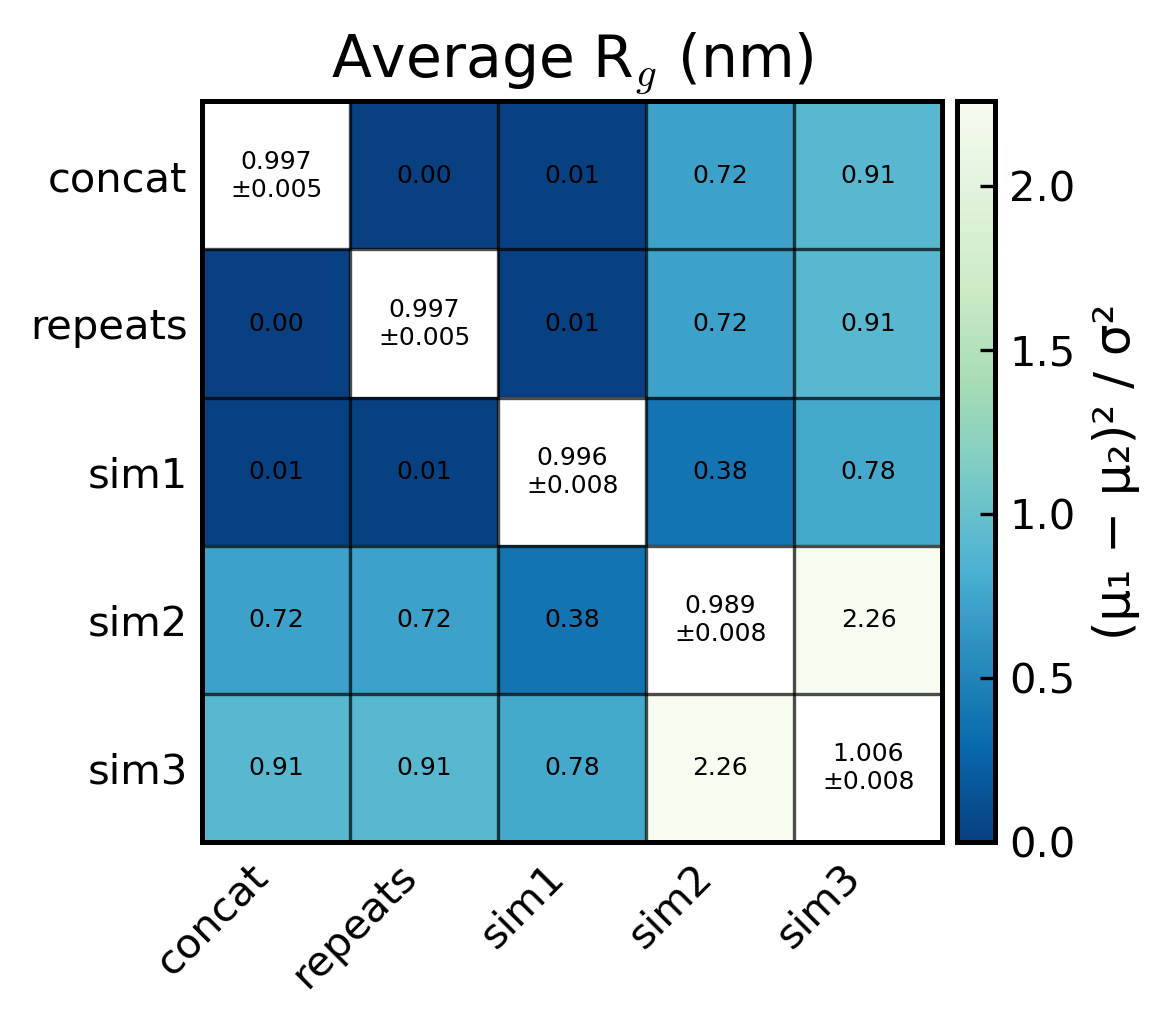

In [42]:
# reduced chi2 and absolute error matrix

dfconcat = pd.read_csv(output_path+f"avg_Rg_at_300K_concat_blocking.csv")
dfrepeats = pd.read_csv(output_path+f"avg_Rg_at_300K_repeatsSEM.csv")
dfsim1 = pd.read_csv(output_path+f"avg_Rg_at_300K_sim1_blocking.csv")
dfsim2 = pd.read_csv(output_path+f"avg_Rg_at_300K_sim2_blocking.csv")
dfsim3 = pd.read_csv(output_path+f"avg_Rg_at_300K_sim3_blocking.csv")


# -------------------------
# Arrange data
# -------------------------
dfs = {
    "concat": dfconcat,
    "repeats": dfrepeats,
    "sim1": dfsim1,
    "sim2": dfsim2,
    "sim3": dfsim3,
}

labels = list(dfs.keys())

values = np.array([df["Rg (nm)"].iloc[0] for df in dfs.values()])
errors = np.array([df["±"].iloc[0] for df in dfs.values()])

n = len(values)

# -------------------------
# Build matrix
# -------------------------
matrix = np.zeros((n, n))

mean_value = np.mean(values)

for i in range(n):
    for j in range(n):
        if i == j:
            # Absolute errors
            matrix[i, j] = errors[i]
        else:
            combined_error = np.sqrt(errors[i]**2 + errors[j]**2)
            matrix[i, j] = (values[i] - values[j])**2 / combined_error**2

# -------------------------
# Plot
# -------------------------
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(4, 4))
import numpy.ma as ma

# Mask diagonal so it is not colored
masked_matrix = ma.masked_where(np.eye(n, dtype=bool), matrix)

im = ax.imshow(masked_matrix, cmap="GnBu_r")

# Labels
ax.set_xticks(np.arange(n))
ax.set_yticks(np.arange(n))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_aspect('equal')
ax.set_title('Average R$_g$ (nm)')

plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

# Annotate cells
for i in range(n):
    for j in range(n):
        if i == j:
            text = f"{values[i]:.3f}\n±{errors[i]:.3f}"
        else:
            text = f"{matrix[i, j]:.2f}"
        ax.text(j, i, text, ha="center", va="center",
                color="black", fontsize=6)

# --- Colorbar with matched height ---
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(im, cax=cax)
cbar.set_label("(μ₁ − μ₂)² / σ²")


# --- Cell outlines (no internal grid lines) ---
ax.set_xticks(np.arange(-0.5, n, 1), minor=True)
ax.set_yticks(np.arange(-0.5, n, 1), minor=True)

ax.grid(which="minor", color="black", linestyle="-", linewidth=0.8)

# Hide all tick marks
ax.tick_params(which="both", bottom=False, left=False, top=False, right=False)

ax.grid(False)
plt.tight_layout()
plt.savefig(output_path+'matrix_avgRg.pdf')



In [34]:
# Rg distribution at 300 K (avg ± std_err) - concat and blocking

kb=0.008314
T0 = 300
kbt = kb*T0
T = 300
nsims = 3
nbins = 50
xmin = 0.6
xmax = 1.5
bin_edges = np.linspace(xmin, xmax, nbins + 1)

# load data and concatenate (and plot distributions of individual trajectories)
for sim in range(nsims):
    if sim==0:
        data = read_colvar(path+f'COLVAR.{sim}')
        CVS = np.loadtxt(path+f'CVS_DATA.{sim}')
        # Time arrays in μs
        time_data = data[:, 0] / 1e6        # ps -> μs
        # Apply cutoff at 5 µs
        mask_data = time_data <= 5.0 
        data = data[mask_data]
        CVS = CVS[mask_data]

    else:
        tmpdata = read_colvar(path+f'COLVAR.{sim}')
        tmpCVS = np.loadtxt(path+f'CVS_DATA.{sim}')
        # Time arrays in μs
        time_data = tmpdata[:, 0] / 1e6        # ps -> μs
        # Apply cutoff at 5 µs
        mask_data = time_data <= 5.0 
        tmpdata = tmpdata[mask_data]
        tmpCVS = tmpCVS[mask_data]
        data = np.concatenate((data, tmpdata), axis=0)
        CVS = np.concatenate((CVS, tmpCVS), axis=0)

# rg of concatenated trajs
rgdata = CVS[:,1]

# weights
bias = data[:,2]
ene = data[:,1] # U
logw = (bias + (1 - T0 / T) * ene) / (kb * T0)
w = softmax(logw)
w = w/np.sum(w)
# remove frames with w=0
mask = w != 0
rgdata = rgdata[mask]
weights_clean = w[mask]

# histogram
counts, bin_edges = np.histogram(rgdata, bins=bin_edges, density=False, weights=weights_clean)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
N = len(rgdata)

probs = np.zeros(nbins)
errs = np.zeros(nbins)

# for each bin build indicator time series and use pyblock
for i in range(nbins):
    left, right = bin_edges[i], bin_edges[i+1]
    # include left edge, exclude right edge except for last bin:
    if i == nbins-1:
        indicator = ((rgdata >= left) & (rgdata <= right)).astype(float)
    else:
        indicator = ((rgdata >= left) & (rgdata < right)).astype(float)

    # if the indicator is constant (no hits or all hits) handle trivially
    if indicator.sum() == 0:
        probs[i] = 0.0
        errs[i] = 0.0
        continue
    if indicator.sum() == N:
        probs[i] = 1.0
        errs[i] = 0.0
        continue

    # run pyblock: reblock returns list-like, find_optimal_block returns index (float -> convert)
    reblocked = pyblock.blocking.reblock(indicator, weights=weights_clean)  # default no weights
    opt = int(pyblock.blocking.find_optimal_block(len(indicator), reblocked)[0])
    mean_bin = np.average(indicator, weights=weights_clean)
    stderr_bin = reblocked[opt].std_err

    probs[i] = mean_bin
    errs[i] = stderr_bin

# sanity: probabilities should sum approx to 1 (if using counts-->probs per-bin)
print("sum probs:", probs.sum())

# save data
df= pd.DataFrame()
df['Rg (nm)'] = bin_centers
df['p(Rg)'] = probs
df['±'] = errs
df.to_csv(output_path+f"prob_Rg_300K_concat_blocking.csv", index=False)

df[:10]

sum probs: 0.9996665943087508


,Rg (nm),p(Rg),±
0,0.609,0.000075,0.000049
1,0.627,0.001019,0.000395
2,0.645,0.002963,0.000629
3,0.663,0.005837,0.000830
4,0.681,0.009724,0.001011
5,0.699,0.012700,0.001104
6,0.717,0.016655,0.001349
7,0.735,0.019868,0.001327
8,0.753,0.028301,0.001495
9,0.771,0.039898,0.002479


In [61]:
# Rg distribution at 300 K (avg ± std_err) - repeats SEM

kb=0.008314
T0 = 300
kbt = kb*T0
T = 300
nsims = 3
nbins = 50
xmin = 0.6
xmax = 1.5
bin_edges = np.linspace(xmin, xmax, nbins + 1)

profiles = []
replica_weights = []

# load data and concatenate (and plot distributions of individual trajectories)
for sim in range(nsims):
    if sim==0:
        data = read_colvar(path+f'COLVAR.{sim}')
        CVS = np.loadtxt(path+f'CVS_DATA.{sim}')
        # Time arrays in μs
        time_data = data[:, 0] / 1e6        # ps -> μs
        # Apply cutoff at 5 µs
        mask_data = time_data <= 5.0 
        data = data[mask_data]
        CVS = CVS[mask_data]
        # weights
        bias = data[:,2]
        ene = data[:,1] # U
        logw = (bias + (1 - T0 / T) * ene) / (kb * T0)
        w = np.exp(logw)
        replica_weights.append(np.sum(w))
        c, b = np.histogram(CVS[:,1], bins=bin_edges, density=False, weights=w)
        profiles.append(c/np.sum(c))
    else:
        data = read_colvar(path+f'COLVAR.{sim}')
        CVS = np.loadtxt(path+f'CVS_DATA.{sim}')
        # Time arrays in μs
        time_data = data[:, 0] / 1e6        # ps -> μs
        # Apply cutoff at 5 µs
        mask_data = time_data <= 5.0 
        data = data[mask_data]
        CVS = CVS[mask_data]
        # weights
        bias = data[:,2]
        ene = data[:,1] # U
        logw = (bias + (1 - T0 / T) * ene) / (kb * T0)
        w = np.exp(logw)
        replica_weights.append(np.sum(w))
        c, b = np.histogram(CVS[:,1], bins=bin_edges, density=False, weights=w)
        profiles.append(c/np.sum(c))

bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
profiles = np.array(profiles)
replica_weights = np.array(replica_weights)
probs = np.average(profiles, weights=replica_weights, axis=0)
errs = np.zeros(nbins)
for i in range(len(probs)):
    errs[i] = weighted_sem([profiles[0][i],profiles[1][i],profiles[2][i]], w=replica_weights)


# sanity: probabilities should sum approx to 1 (if using counts-->probs per-bin)
print("sum probs:", probs.sum())

# save data
df= pd.DataFrame()
df['Rg (nm)'] = bin_centers
df['p(Rg)'] = probs
df['±'] = errs
df.to_csv(output_path+f"prob_Rg_300K_repeatsSEM.csv", index=False)

df[:10]

sum probs: 1.0


,Rg (nm),p(Rg),±
0,0.609,0.000075,0.000041
1,0.627,0.001020,0.000496
2,0.645,0.002964,0.000652
3,0.663,0.005840,0.000549
4,0.681,0.009728,0.001367
5,0.699,0.012705,0.001061
6,0.717,0.016660,0.000031
7,0.735,0.019875,0.001138
8,0.753,0.028310,0.001448
9,0.771,0.039911,0.005136


In [64]:
# Rg distribution at 300 K (avg ± std_err) - individual simulations blocking

sim= 2

kb=0.008314
T0 = 300
kbt = kb*T0
T = 300
nsims = 3
nbins = 50
xmin = 0.6
xmax = 1.5
bin_edges = np.linspace(xmin, xmax, nbins + 1)

# load data and concatenate (and plot distributions of individual trajectories)

data = read_colvar(path+f'COLVAR.{sim}')
CVS = np.loadtxt(path+f'CVS_DATA.{sim}')
# Time arrays in μs
time_data = data[:, 0] / 1e6        # ps -> μs
# Apply cutoff at 5 µs
mask_data = time_data <= 5.0 
data = data[mask_data]
CVS = CVS[mask_data]


# rg of concatenated trajs
rgdata = CVS[:,1]

# weights
bias = data[:,2]
ene = data[:,1] # U
logw = (bias + (1 - T0 / T) * ene) / (kb * T0)
w = softmax(logw)
w = w/np.sum(w)
# remove frames with w=0
mask = w != 0
rgdata = rgdata[mask]
weights_clean = w[mask]

# histogram
counts, bin_edges = np.histogram(rgdata, bins=bin_edges, density=False, weights=weights_clean)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
N = len(rgdata)

probs = np.zeros(nbins)
errs = np.zeros(nbins)

# for each bin build indicator time series and use pyblock
for i in range(nbins):
    left, right = bin_edges[i], bin_edges[i+1]
    # include left edge, exclude right edge except for last bin:
    if i == nbins-1:
        indicator = ((rgdata >= left) & (rgdata <= right)).astype(float)
    else:
        indicator = ((rgdata >= left) & (rgdata < right)).astype(float)

    # if the indicator is constant (no hits or all hits) handle trivially
    if indicator.sum() == 0:
        probs[i] = 0.0
        errs[i] = 0.0
        continue
    if indicator.sum() == N:
        probs[i] = 1.0
        errs[i] = 0.0
        continue

    # run pyblock: reblock returns list-like, find_optimal_block returns index (float -> convert)
    reblocked = pyblock.blocking.reblock(indicator, weights=weights_clean)  # default no weights
    opt = int(pyblock.blocking.find_optimal_block(len(indicator), reblocked)[0])
    mean_bin = np.average(indicator, weights=weights_clean)
    stderr_bin = reblocked[opt].std_err

    probs[i] = mean_bin
    errs[i] = stderr_bin

# sanity: probabilities should sum approx to 1 (if using counts-->probs per-bin)
print("sum probs:", probs.sum())

# save data
df= pd.DataFrame()
df['Rg (nm)'] = bin_centers
df['p(Rg)'] = probs
df['±'] = errs
df.to_csv(output_path+f"prob_Rg_300K_sim{sim+1}_blocking.csv", index=False)

df[:10]

sum probs: 0.9998922156812643


,Rg (nm),p(Rg),±
0,0.609,0.000137,0.000105
1,0.627,0.001860,0.000966
2,0.645,0.003550,0.001128
3,0.663,0.004887,0.001112
4,0.681,0.012203,0.002001
5,0.699,0.013683,0.001858
6,0.717,0.016662,0.002099
7,0.735,0.020381,0.002216
8,0.753,0.026357,0.002658
9,0.771,0.034500,0.003362


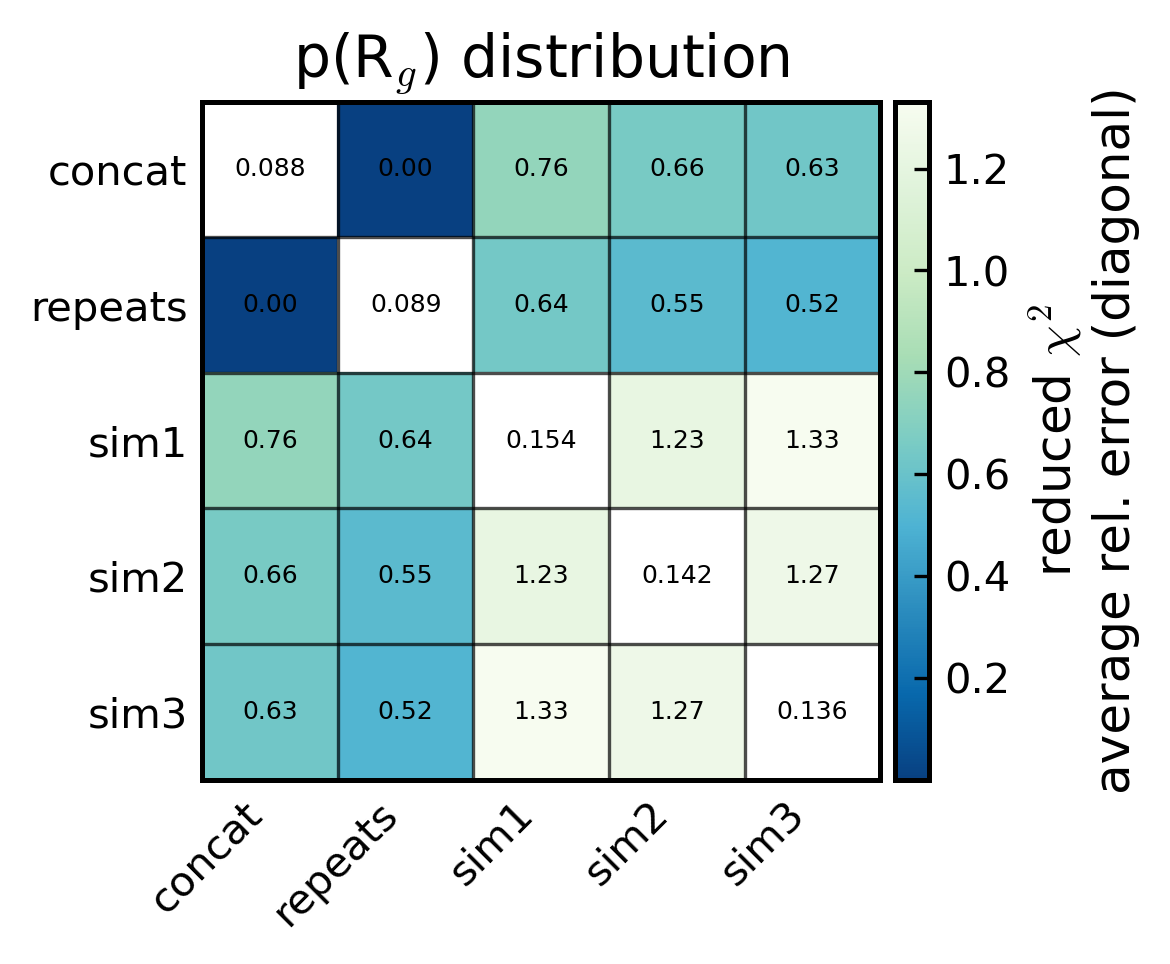

In [80]:
# reduced chi2 and absolute error matrix

dfconcat = pd.read_csv(output_path+f"prob_Rg_300K_concat_blocking.csv")
dfrepeats = pd.read_csv(output_path+f"prob_Rg_300K_repeatsSEM.csv")
dfsim1 = pd.read_csv(output_path+f"prob_Rg_300K_sim1_blocking.csv")
dfsim2 = pd.read_csv(output_path+f"prob_Rg_300K_sim2_blocking.csv")
dfsim3 = pd.read_csv(output_path+f"prob_Rg_300K_sim3_blocking.csv")


# -------------------------
# Arrange data
# -------------------------
dfs = {
    "concat": dfconcat,
    "repeats": dfrepeats,
    "sim1": dfsim1,
    "sim2": dfsim2,
    "sim3": dfsim3,
}

labels = list(dfs.keys())

values = np.array([df["p(Rg)"] for df in dfs.values()])
errors = np.array([df["±"] for df in dfs.values()])

n = len(values)

# -------------------------
# Build matrix
# -------------------------
matrix = np.zeros((n, n))

mean_value = np.mean(values)

for i in range(n):
    for j in range(n):
        if i == j:
            # Absolute errors
            matrix[i, j] = float(0)
        else:
            combined_error = np.sqrt(errors[i,:]**2 + errors[j,:]**2)
            matrix[i, j] = np.mean((values[i,:] - values[j,:])**2 / combined_error**2)

# -------------------------
# Plot
# -------------------------
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(4, 4))
import numpy.ma as ma

# Mask diagonal so it is not colored
masked_matrix = ma.masked_where(np.eye(n, dtype=bool), matrix)

im = ax.imshow(masked_matrix, cmap="GnBu_r")

# Labels
ax.set_xticks(np.arange(n))
ax.set_yticks(np.arange(n))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_aspect('equal')
ax.set_title('p(R$_g$) distribution')

plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

# Annotate cells
for i in range(n):
    for j in range(n):
        if i == j:
            text = f"{np.mean(errors[i,:]/values[i,:]):.3f}"
        else:
            text = f"{matrix[i, j]:.2f}"
        ax.text(j, i, text, ha="center", va="center",
                color="black", fontsize=6)

# --- Colorbar with matched height ---
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(im, cax=cax)
cbar.set_label("reduced $\chi^2$\naverage rel. error (diagonal)")


# --- Cell outlines (no internal grid lines) ---
ax.set_xticks(np.arange(-0.5, n, 1), minor=True)
ax.set_yticks(np.arange(-0.5, n, 1), minor=True)

ax.grid(which="minor", color="black", linestyle="-", linewidth=0.8)

# Hide all tick marks
ax.tick_params(which="both", bottom=False, left=False, top=False, right=False)

ax.grid(False)
plt.tight_layout()
plt.savefig(output_path+'matrix_prob_Rg.pdf')



In [82]:
# Helicity at 300 K - concat and blocking

kb=0.008314
T0 = 300
kbt = kb*T0
nsims = 3
T = 300
residues = np.arange(1, 17+1)

# load data and concatenate (and plot individual profiles)
for sim in range(nsims):
    if sim==0:
        data = read_colvar(path+f'COLVAR.{sim}')
        with open(path+f'dssp{sim}.dat') as f:
            dssp = [line.strip() for line in f]
        # Time arrays in μs
        time_data = data[:, 0] / 1e6        # ps -> μs
        # Apply cutoff at 5 µs
        mask_data = time_data <= 5.0 
        data = data[mask_data]
        dssp =  np.array(dssp)[mask_data]
    
    else:
        tmpdata = read_colvar(path+f'COLVAR.{sim}')
        with open(path+f'dssp{sim}.dat') as f:
            tmpdssp = [line.strip() for line in f]
        # Time arrays in μs
        time_data = tmpdata[:, 0] / 1e6        # ps -> μs
        # Apply cutoff at 5 µs
        mask_data = time_data <= 5.0 
        tmpdata = tmpdata[mask_data]
        tmpdssp = np.array(tmpdssp)[mask_data]
        data = np.concatenate((data, tmpdata), axis=0)
        dssp = np.concatenate((dssp, tmpdssp), axis=0)

        
# helicity for all, concatenated frames
bias = data[:,2]
ene = data[:,1] # U
logw = (bias + (1 - T0 / T) * ene) / (kb * T0)
w = softmax(logw)
w = w/np.sum(w)
# remove frames with w=0
mask = w != 0
weights_clean = w[mask]
H = dssp_to_helicity(dssp[mask])

# H: shape (n_frames, n_residues)
n_frames, n_residues = H.shape

means = np.zeros(n_residues)
stderr = np.zeros(n_residues)

for j in range(n_residues):
    series = H[:, j]  # helicity time series for residue j
    if np.mean(series)==0:
        means[j] = float(0)
        stderr[j] = float(0)
        continue
    reblock_data = pyblock.blocking.reblock(series, weights=weights_clean)
    optimal = int(pyblock.blocking.find_optimal_block(len(series), reblock_data)[0])
    means[j] = np.average(series, weights=weights_clean)
    stderr[j] = reblock_data[optimal].std_err

# save data
df= pd.DataFrame()
df['Residue'] = residues[1:-2] # only residues with helical propensity
df['Fraction helix'] = means[1:-2]
df['±'] = stderr[1:-2]
df.to_csv(output_path+f"perres_helicity_300K_concat_blocking.csv", index=False)
df

,Residue,Fraction helix,±
0,2,0.113977,0.008003
1,3,0.136385,0.010297
2,4,0.159576,0.010926
3,5,0.181392,0.010997
4,6,0.231637,0.012820
5,7,0.248215,0.013203
6,8,0.239527,0.013472
7,9,0.233632,0.013336
8,10,0.218928,0.012485
9,11,0.200035,0.011223


In [86]:
# Helicity at 300 K - repeats SEM

kb=0.008314
T0 = 300
kbt = kb*T0
nsims = 3
T = 300
residues = np.arange(1, 17+1)


profiles = []
replica_weights = []
# load data and concatenate (and plot individual profiles)
for sim in range(nsims):
    if sim==0:
        data = read_colvar(path+f'COLVAR.{sim}')
        with open(path+f'dssp{sim}.dat') as f:
            dssp = [line.strip() for line in f]
        # Time arrays in μs
        time_data = data[:, 0] / 1e6        # ps -> μs
        # Apply cutoff at 5 µs
        mask_data = time_data <= 5.0 
        data = data[mask_data]
        dssp =  np.array(dssp)[mask_data]
        # helicity for all, concatenated frames
        bias = data[:,2]
        ene = data[:,1] # U
        logw = (bias + (1 - T0 / T) * ene) / (kb * T0)
        w = np.exp(logw)
        H = dssp_to_helicity(dssp)
        profile = np.average(H, axis=0, weights=w)
        replica_weights.append(np.sum(w))
        profiles.append(profile)
    
    else:
        data = read_colvar(path+f'COLVAR.{sim}')
        with open(path+f'dssp{sim}.dat') as f:
            dssp = [line.strip() for line in f]
        # Time arrays in μs
        time_data = data[:, 0] / 1e6        # ps -> μs
        # Apply cutoff at 5 µs
        mask_data = time_data <= 5.0 
        data = data[mask_data]
        dssp =  np.array(dssp)[mask_data]
        # helicity for all, concatenated frames
        bias = data[:,2]
        ene = data[:,1] # U
        logw = (bias + (1 - T0 / T) * ene) / (kb * T0)
        w = np.exp(logw)
        H = dssp_to_helicity(dssp)
        profile = np.average(H, axis=0, weights=w)
        replica_weights.append(np.sum(w))
        profiles.append(profile)

        
profiles = np.array(profiles)
replica_weights = np.array(replica_weights)
means = np.average(profiles, axis=0, weights=replica_weights)
stderr = np.zeros(len(means))
for i in range(len(means)):
    stderr[i] = weighted_sem([profiles[0][i], profiles[1][i], profiles[2][i]], w=replica_weights)

# save data
df= pd.DataFrame()
df['Residue'] = residues[1:-2] # only residues with helical propensity
df['Fraction helix'] = means[1:-2]
df['±'] = stderr[1:-2]
df.to_csv(output_path+f"perres_helicity_300K_repeatsSEM.csv", index=False)
df

,Residue,Fraction helix,±
0,2,0.113977,0.004301
1,3,0.136385,0.003717
2,4,0.159576,0.004924
3,5,0.181392,0.005950
4,6,0.231637,0.007312
5,7,0.248215,0.014221
6,8,0.239527,0.015664
7,9,0.233632,0.015067
8,10,0.218928,0.014110
9,11,0.200035,0.010332


In [89]:
# Helicity at 300 K - individual sims blocking

sim=2

kb=0.008314
T0 = 300
kbt = kb*T0
nsims = 3
T = 300
residues = np.arange(1, 17+1)

# load data and concatenate (and plot individual profiles)

data = read_colvar(path+f'COLVAR.{sim}')
with open(path+f'dssp{sim}.dat') as f:
    dssp = [line.strip() for line in f]
# Time arrays in μs
time_data = data[:, 0] / 1e6        # ps -> μs
# Apply cutoff at 5 µs
mask_data = time_data <= 5.0 
data = data[mask_data]
dssp =  np.array(dssp)[mask_data]
    

# helicity for all, concatenated frames
bias = data[:,2]
ene = data[:,1] # U
logw = (bias + (1 - T0 / T) * ene) / (kb * T0)
w = softmax(logw)
w = w/np.sum(w)
# remove frames with w=0
mask = w != 0
weights_clean = w[mask]
H = dssp_to_helicity(dssp[mask])

# H: shape (n_frames, n_residues)
n_frames, n_residues = H.shape

means = np.zeros(n_residues)
stderr = np.zeros(n_residues)

for j in range(n_residues):
    series = H[:, j]  # helicity time series for residue j
    if np.mean(series)==0:
        means[j] = float(0)
        stderr[j] = float(0)
        continue
    reblock_data = pyblock.blocking.reblock(series, weights=weights_clean)
    optimal = int(pyblock.blocking.find_optimal_block(len(series), reblock_data)[0])
    means[j] = np.average(series, weights=weights_clean)
    stderr[j] = reblock_data[optimal].std_err

# save data
df= pd.DataFrame()
df['Residue'] = residues[1:-2] # only residues with helical propensity
df['Fraction helix'] = means[1:-2]
df['±'] = stderr[1:-2]
df.to_csv(output_path+f"perres_helicity_300K_sim{sim+1}_blocking.csv", index=False)
df

,Residue,Fraction helix,±
0,2,0.115844,0.013590
1,3,0.136361,0.015621
2,4,0.164136,0.016907
3,5,0.182133,0.016985
4,6,0.217203,0.018718
5,7,0.219954,0.019266
6,8,0.209004,0.019243
7,9,0.203734,0.019553
8,10,0.191059,0.018469
9,11,0.179418,0.017138


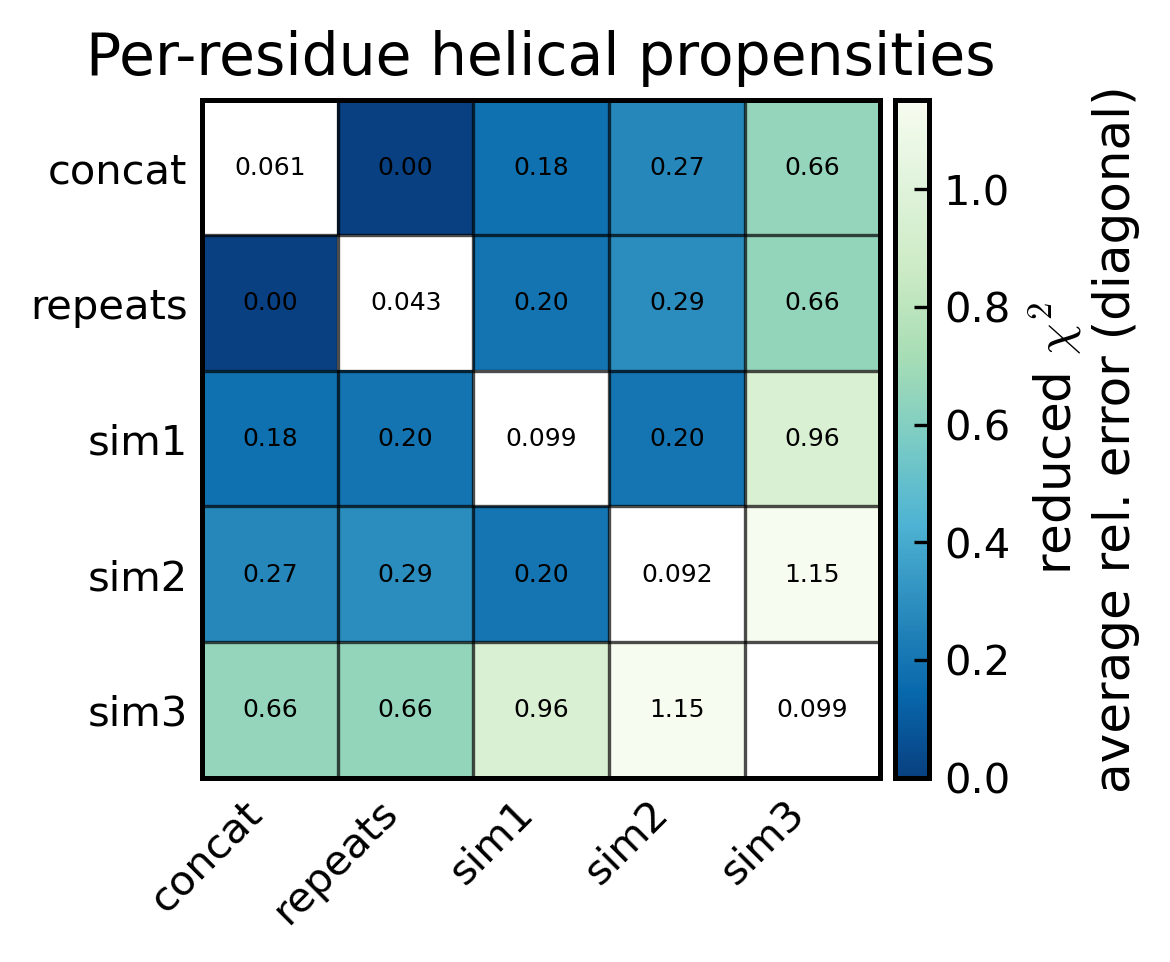

In [90]:
# reduced chi2 and absolute error matrix

dfconcat = pd.read_csv(output_path+f"perres_helicity_300K_concat_blocking.csv")
dfrepeats = pd.read_csv(output_path+f"perres_helicity_300K_repeatsSEM.csv")
dfsim1 = pd.read_csv(output_path+f"perres_helicity_300K_sim1_blocking.csv")
dfsim2 = pd.read_csv(output_path+f"perres_helicity_300K_sim2_blocking.csv")
dfsim3 = pd.read_csv(output_path+f"perres_helicity_300K_sim3_blocking.csv")


# -------------------------
# Arrange data
# -------------------------
dfs = {
    "concat": dfconcat,
    "repeats": dfrepeats,
    "sim1": dfsim1,
    "sim2": dfsim2,
    "sim3": dfsim3,
}

labels = list(dfs.keys())

values = np.array([df["Fraction helix"] for df in dfs.values()])
errors = np.array([df["±"] for df in dfs.values()])

n = len(values)

# -------------------------
# Build matrix
# -------------------------
matrix = np.zeros((n, n))

mean_value = np.mean(values)

for i in range(n):
    for j in range(n):
        if i == j:
            # Absolute errors
            matrix[i, j] = float(0)
        else:
            combined_error = np.sqrt(errors[i,:]**2 + errors[j,:]**2)
            matrix[i, j] = np.mean((values[i,:] - values[j,:])**2 / combined_error**2)

# -------------------------
# Plot
# -------------------------
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(4, 4))
import numpy.ma as ma

# Mask diagonal so it is not colored
masked_matrix = ma.masked_where(np.eye(n, dtype=bool), matrix)

im = ax.imshow(masked_matrix, cmap="GnBu_r")

# Labels
ax.set_xticks(np.arange(n))
ax.set_yticks(np.arange(n))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_aspect('equal')
ax.set_title('Per-residue helical propensities')

plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

# Annotate cells
for i in range(n):
    for j in range(n):
        if i == j:
            text = f"{np.mean(errors[i,:]/values[i,:]):.3f}"
        else:
            text = f"{matrix[i, j]:.2f}"
        ax.text(j, i, text, ha="center", va="center",
                color="black", fontsize=6)

# --- Colorbar with matched height ---
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(im, cax=cax)
cbar.set_label("reduced $\chi^2$\naverage rel. error (diagonal)")


# --- Cell outlines (no internal grid lines) ---
ax.set_xticks(np.arange(-0.5, n, 1), minor=True)
ax.set_yticks(np.arange(-0.5, n, 1), minor=True)

ax.grid(which="minor", color="black", linestyle="-", linewidth=0.8)

# Hide all tick marks
ax.tick_params(which="both", bottom=False, left=False, top=False, right=False)

ax.grid(False)
plt.tight_layout()
plt.savefig(output_path+'matrix_perres_helicity.pdf')

